### Clustering
We use a simple k-means algorithm to demonstrate how clustering can be done. Clustering can help discover valuable, hidden groupings within the data. The dataset is created in the Obtain_dataset.ipynb.

In [23]:
# imports
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import openai
openai.api_key = "OPENAI_API_KEY"


In [24]:
# load data
datafile_path = "../data/Embedding_Issues.csv"

df = pd.read_csv(datafile_path)
df["embedding"] = df.embedding.apply(eval).apply(np.array)  # convert string to numpy array
matrix = np.vstack(df.embedding.values)
matrix.shape

size_to_num = {'XS': 0, 'S': 1, 'M': 2, 'L': 3, 'XL': 4}
df['Size_num'] = df['Size'].map(size_to_num)

### Find the clusters using K-means
We show the simplest use of K-means. You can pick the number of clusters that fits your use case best.

In [11]:
n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
df["Cluster"] = labels

df.groupby("Cluster").Size_num.mean().sort_values()

/Users/williank/Projects/data/sites/admin.data/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster
0    0.300000
2    1.025000
1    1.806452
3    2.250000
Name: Size_num, dtype: float64

In [12]:
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

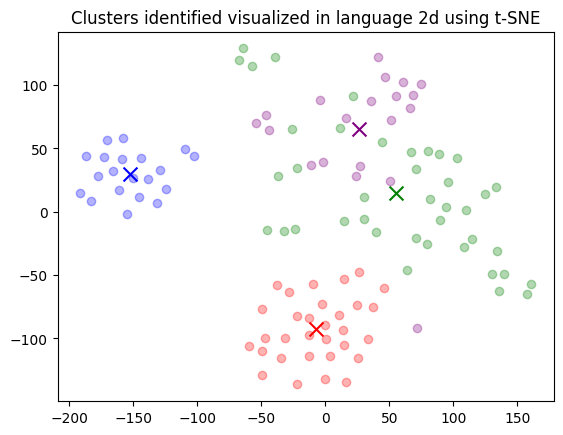

In [14]:
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["blue", "red", "green", "purple"]):
    xs = np.array(x)[df.Cluster == category]
    ys = np.array(y)[df.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")

### Text samples in the clusters & naming the clusters
Let's show random samples from each cluster. We'll use text-davinci-003 to name the clusters, based on a random sample of 5 reviews from that cluster.

In [ ]:
# Reading a review which belong to each group.
rev_per_cluster = 1

for i in range(n_clusters):
    print(f"Cluster {i} Theme:", end=" ")

    reviews = "\n".join(
        df[df.Cluster == i]
        .combined.str.replace("Title: ", "")
        .str.replace("\n\nContent: ", ":  ")
        .sample(rev_per_cluster, random_state=42)
        .values
    )
    response = openai.Completion.create(
        engine="text-davinci-003",
        prompt=f'What do the following tickets have in common?\n\nTickets:\n"""\n{reviews}\n"""\n\nTheme:',
        temperature=0,
        max_tokens=64,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )
    print(response["choices"][0]["text"].replace("\n", ""))

    sample_cluster_rows = df[df.Cluster == i].sample(rev_per_cluster, random_state=42)
    for j in range(rev_per_cluster):
        print(sample_cluster_rows.Size.values[j], end=", ")
        print(sample_cluster_rows.Summary.values[j], end=":   ")
        print(sample_cluster_rows.Description.str[:70].values[j])

    print("-" * 100)